In [3]:
include("/home/pablo/Biofilms/scripts/biofilm_surface_growth/surface_functions.jl")

# Biofilm height growth - nutrient arguments 

Biofilms are qualitatively and quantitatively different forms of life than their planktonic counterparts. When observing growth curves, there is an **early** ($<5h$) regime where it behaves exponential, but then it slows down.

My hipothesis is that this is an effect of nutrient dynamics (**not availability!**), the fact that there is a defined interface between the nutrient-rich location, the LB-agar, and the nutrient expenders, the biofilm growing attached to the surface.

This *should* explain:
1. the $z(t)$ dynamics (when we add a death term, no spores)
2. the change between exponential to linear growth
3. $\dot{z}(t) = F(z)$

As the *best* benchmark for this kind of biofilm-nutrient dynamics we can use as reference the work from [Srinivasan et al. (2019)](https://elifesciences.org/articles/42697) and [Fei et al. (2020)](https://www.pnas.org/content/117/14/7622.abstract).

For biofilms, the population growth term and nutrient uptake, respectively are:

$g_1(h, c, \phi) = G h \phi \frac{c}{K + c} \left(1 - \frac{h \phi}{H \phi_0} \right) \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad g_2(h, c, \phi) = \frac{\Gamma \phi h}{d} \frac{c}{K + c}$

Here, we note the prevalence of planktonic growth dynamics, since the term $h \phi \left(1 - \frac{h \phi}{H \phi_0} \right)$ is not even discussed on the derivation. Regardless, we can try to simplify the model as much as possible in order to see if the predictions *fit* in our height measurements.

$\dot{b} = \alpha b \frac{c}{K_{c} + c} \left(1-\frac{b}{K_b}\right) \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \dot{c} = \beta b \frac{c}{K_{c}+c}$

$\dot{b} = G(b)*\frac{c}{K_{c} + c} - \beta*b$

**Note**: a logistic uptake was also my assumption on the first biomass model iteration!

## I. Nutrient-dependent, logistic and interface limited models

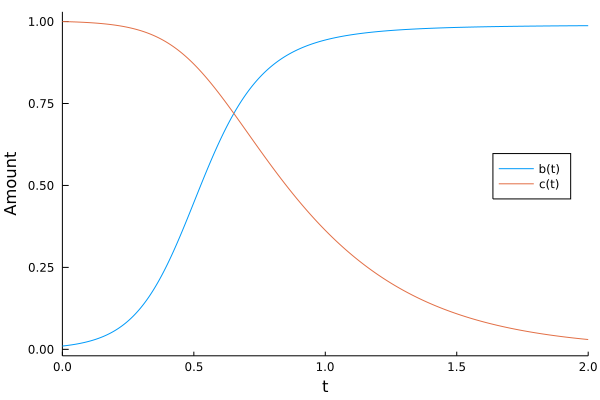

In [4]:
nl_sol = nutrient_limited()
plot(nl_sol, grid=false, legend=:right, ylabel="Amount")

Looks reasonable! **Unless** you have actually taken height timelapses and seen that this is **not how it looks!**. The model curve $b(t)$ is symmetric and it reaches equilibrium quite fast, in real biofilms there's a long period in which it grows linearly. Here we'll load radial profiles and compare how the height in the homeland ~$b(t)$ compares to the model. Still, the way the nutrient concentration decays is better than I had, should definitely look into it.

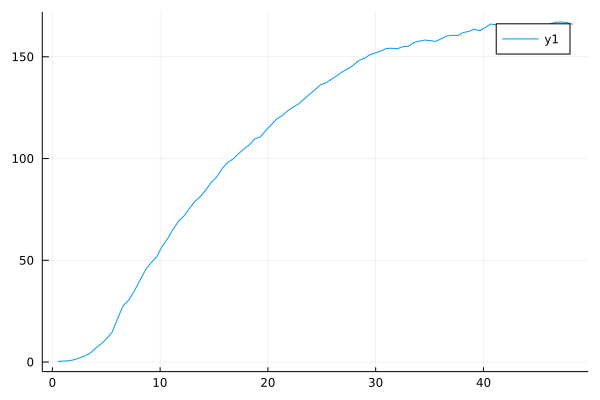

In [5]:
t_experiment, h_experiment = experimental_heights("SN503", "A")
plot(t_experiment, h_experiment)

In [ ]:
tspan = (0.0, 72.0)
tags = ["Early", "Middle", "Late"]
u0 = [[b => 0.5, c => 10], [b => 9, c => 10], [b => 10, c => 10]]
p = [[α => 1.95, β => 0.01, Kb => 167.0, Kc => 21],
     [α => 2.5, β => 0.01, Kb => 135.0, Kc => 100],
     [α => 2.0, β => 0.01, Kb => 167.0, Kc => 100]]

p1 = plot()
Y = []
for i=1:3
     prob = ODEProblem(ODESystem(eqs),u0[i],tspan,p[i])
     sol = solve(prob, Tsit5(), saveat=0.1)
     p1 = plot!(sol, vars=b, label=tags[i], linewidth=2)
     push!(Y, reduce(hcat, sol.u)[1,:])
end
p1 = scatter!(t_experiment, h_experiment, label="Experimental", legend=:topleft, color=:black, alpha=0.5, xlim=(0, 49))

But when we introduce the **saturation function** $G(x)$ we get a great fit for the data!

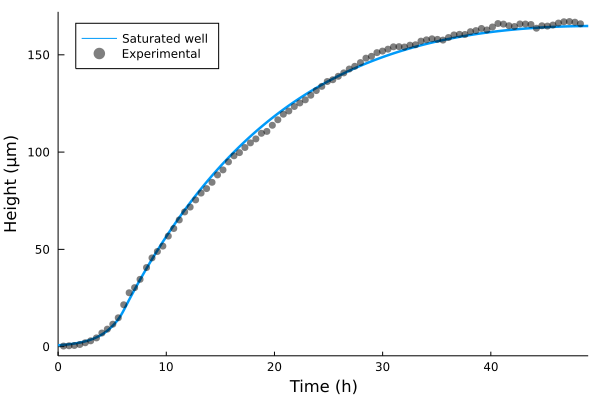

In [14]:
tspan = (0.0, 72.0)
if_sol = interface_limited()
p1 = plot(if_sol, grid=false, legend=:right,xlabel="Time (h)", ylabel="Height (μm)", xlim=(0,49), vars=b, label="Saturated well", linewidth=2.5)
p1 = scatter!(t_experiment, h_experiment, label="Experimental", legend=:topleft, color=:black, alpha=0.5, dpi=100)


## II. Fitting models to the experimental data

While in the previous section we did an *eye-fit* to the data, that obviously introduces *bias*, but it serves the purpose of introducing the behavior of the different models. As well as the obvious downfalls of the first two. Now we will optimize the system of PDEs to actually fit the data and compare them: